# A Simple Framework for Contrastive Learning of Visual Representations

В ходе данной работы предстоит реализация модели ```SimCLR```

Подробнее о принципах работы которой можно прочитать на <code>[github][1]

[1]: https://github.com/modernTalker/IITP.git       "github"
</code>

Подкоючим все необходимые библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F

import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os
from pathlib import Path

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Работу будем производить с датасетом ```CIFAR10```

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=True, transform=transforms.ToTensor()
)

# Данные для тестирования
val_dataset = torchvision.datasets.CIFAR10(
    root="./cifar", download=True, train=False, transform=transforms.ToTensor()
)

100%|██████████| 170498071/170498071 [00:02<00:00, 74057366.56it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


Разделим данные на объекты и лейблы

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

# Получаем данные
for train_X, train_y in train_loader:
    break

for val_X, val_y in val_loader:
    break

В качестве внутренней модели будем использовать ```ResNet-50```

In [ ]:
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 128)
).to(device)

Определим функцию подсчета ошибки ```NT-Xent loss```

In [ ]:
# Контрастная функция потерь
def compute_loss(model, images, tmp=0.5):
    # Создаем аугментации
    images_aug1 = augment_fn(images)
    images_aug2 = augment_fn(images)

    # Передаем картинки в модель
    z1 = model(images_aug1)
    z2 = model(images_aug2)

    # Считаем похожесть пар
    sim_pairs = F.cosine_similarity(z1[None,:,:], z2[:,None,:], dim=-1)

    # Ставим контрастные метки
    target = torch.arange(sim_pairs.shape[0]).to(device)

    # Считаем loss
    loss = F.cross_entropy(sim_pairs / tmp, target, reduction="mean")

    return loss

Далее определим применяемые к данным аугментации

In [ ]:
def augment_fn(images):
    augmented_images = augmentation_technique(images)
    augmented_images = augmented_images.to(device)
    return augmented_images

# Функция, аугментирующая картинки
def augmentation_technique(images):

    # Переводим изображения в PIL формат
    pil_images = [transforms.ToPILImage()(image) for image in images]

    # Объявляем изменения
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ColorJitter((0.5, 1.5)),
        transforms.ToTensor()
    ])

    # Применяем изменения к каждой картинке
    augmented_images = [transform(image) for image in pil_images]

    # Храним изменения для картинок в тензоре
    augmented_images = torch.stack(augmented_images)

    return augmented_images

Функция для визуализации применяемых аугментаций

In [ ]:
def plot_augmented_images(images):

    num_images = images.shape[0]

    # Применим аугментацию
    augmented_images = augmentation_technique(images)

    fig, axes = plt.subplots(num_images, 2, figsize=(32, 32))

    for i in range(num_images):
        # Выведем оригинальное изображение
        img = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Оригинал #{i+1}')

        # Выведем аугментированное
        aug_img = np.transpose(augmented_images[i].cpu().numpy(), (1, 2, 0))
        axes[i, 1].imshow(aug_img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Аугментация #{i+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
sample_images, _ = next(iter(train_loader))  # Возьмем серию объектов из датасета
images = sample_images[:3]
print(images.type(), images.shape)

torch.FloatTensor torch.Size([3, 3, 32, 32])


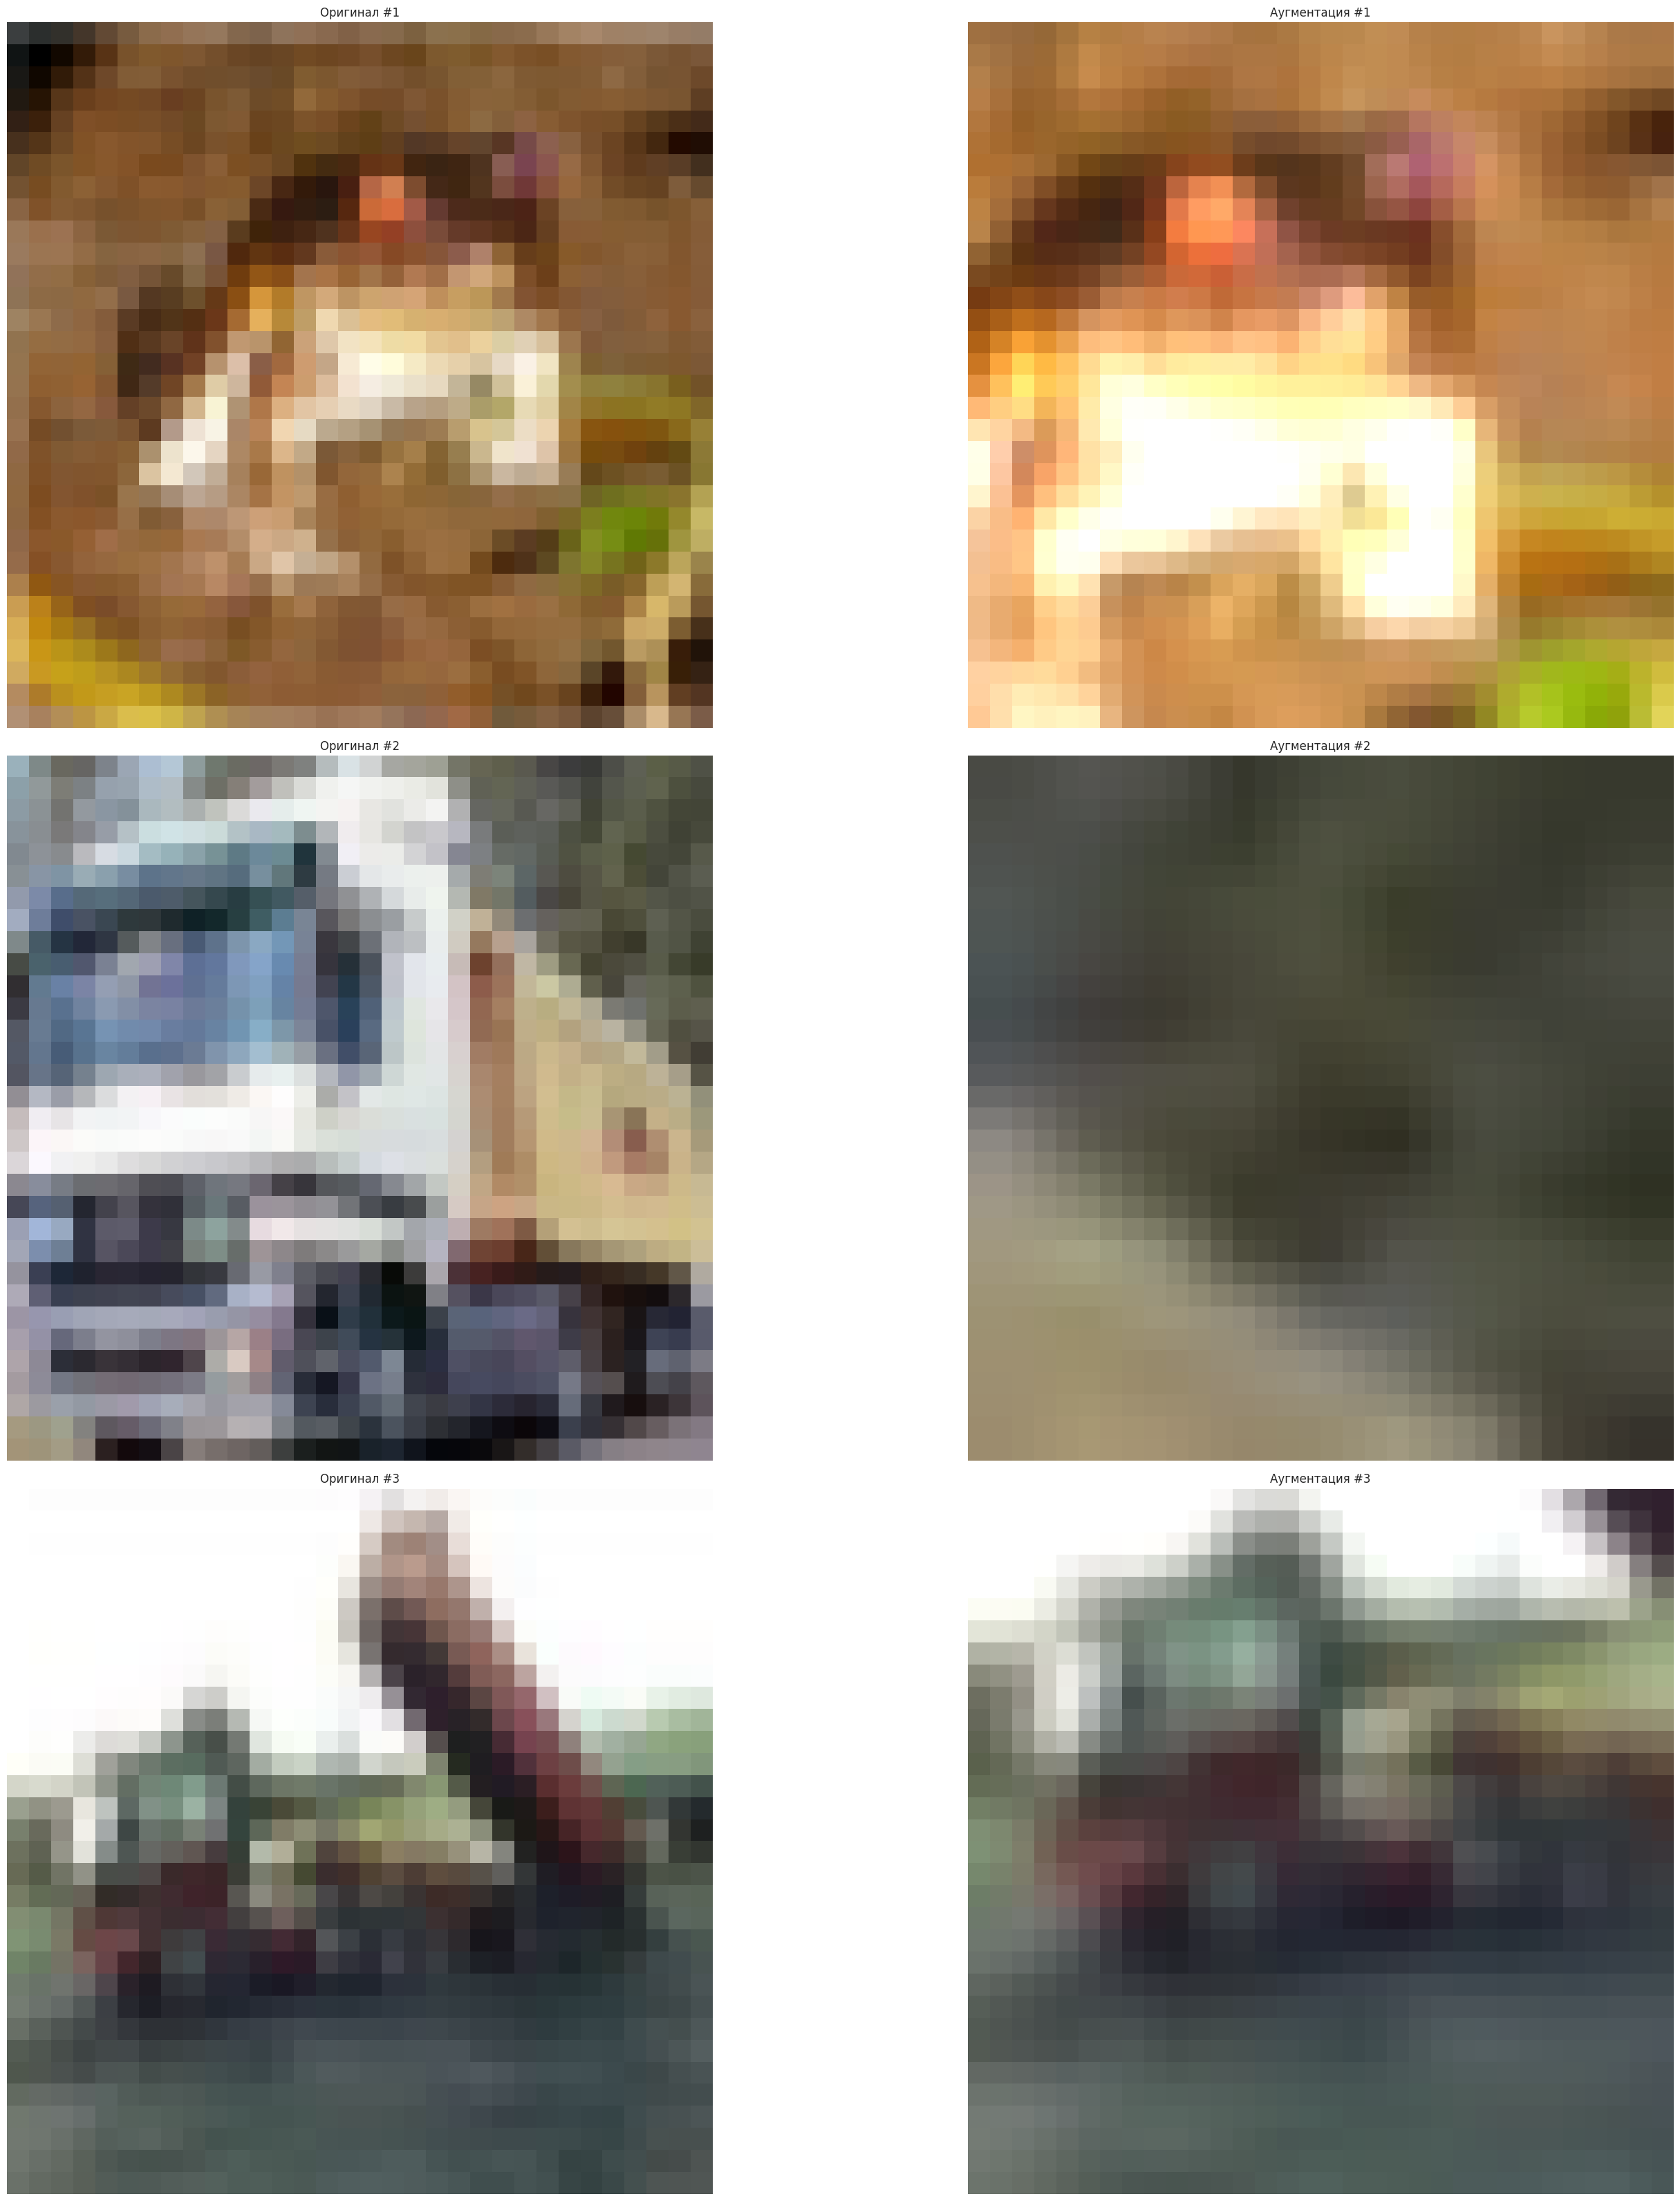

In [ ]:
plot_augmented_images(images)

Перейдем к обучению модели, определим ряд функций, которые будут удобны для визуализации прогресса во время обучения модели

In [ ]:
def update_history(history, loss, acc, num_batches, mode):
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)

In [ ]:
def print_epoch(epoch, num_epochs, history, t):

    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


In [ ]:
def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = torch.tensor(X_batch).to(device)
    y_batch = torch.tensor(y_batch).to(device)

    logits = model(X_batch)
    loss = criterion(model, X_batch)

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc

Основной цикл обучения

In [ ]:
def train(
    model, X, Y, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=10,
):

    # Распакуем подаваемые данные
    train_X, val_X = X
    train_y, val_y = Y

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным

        train_batches = train_batch_gen(train_X, train_y)

        for X_batch, y_batch in train_batches:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batches), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов

        val_batches = val_batch_gen(val_X, val_y)

        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batches:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batches), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

Генераторы батчей

In [ ]:
def train_batch_gen(X, y, batch_size=64):
    assert X.shape[0] == y.shape[0]
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    batches = []
    for batch_start in range(len(X) // batch_size):
        start_idx = batch_start * batch_size
        end_idx = start_idx + batch_size
        batch_X = X[perm[start_idx:end_idx]]
        batch_y = y[perm[start_idx:end_idx]]
        batches.append((batch_X, batch_y))

    return batches

In [ ]:
def val_batch_gen(X, y, batch_size=64):
    assert X.shape[0] == y.shape[0]

    batches = []
    for batch_start in range(len(X) // batch_size):
        start_idx = batch_start * batch_size
        end_idx = start_idx + batch_size
        batches.append((X[start_idx:end_idx], y[start_idx:end_idx]))

    return batches

Обучение модели

In [ ]:
def fit_network(model, train_X, val_X, train_y, val_y):
  criterion = compute_loss
  optimizer = torch.optim.Adam(model.parameters())
  model.to(device)
  X = (train_X, val_X)
  Y = (train_y, val_y)
  return train(model, X, Y,  criterion, optimizer, train_batch_gen, val_batch_gen)

In [ ]:
history = fit_network(model, train_X, val_X, train_y, val_y)

Epoch 10 of 10 took 143.181 s
  training loss: 	2.638101
  validation loss: 	2.676966
  training accuracy: 			0.84 %
  validation accuracy: 			0.65 %


In [ ]:
torch.save(model.state_dict(), "model_10_epochs.pth")

Для визуализации обучения

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "mediumslateblue"]
    epochs = min([len(h["loss"]["train"]) for h in histories])

    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Training Loss")
        axs[0].plot(history["loss"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i])
        axs[0].set_xlabel("Epochs")

        axs[1].set_title("Validation Loss")
        axs[1].plot(history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--", label=f"{name}")
        axs[1].set_xlabel("Epochs")

    for ax in axs.flat:
        ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

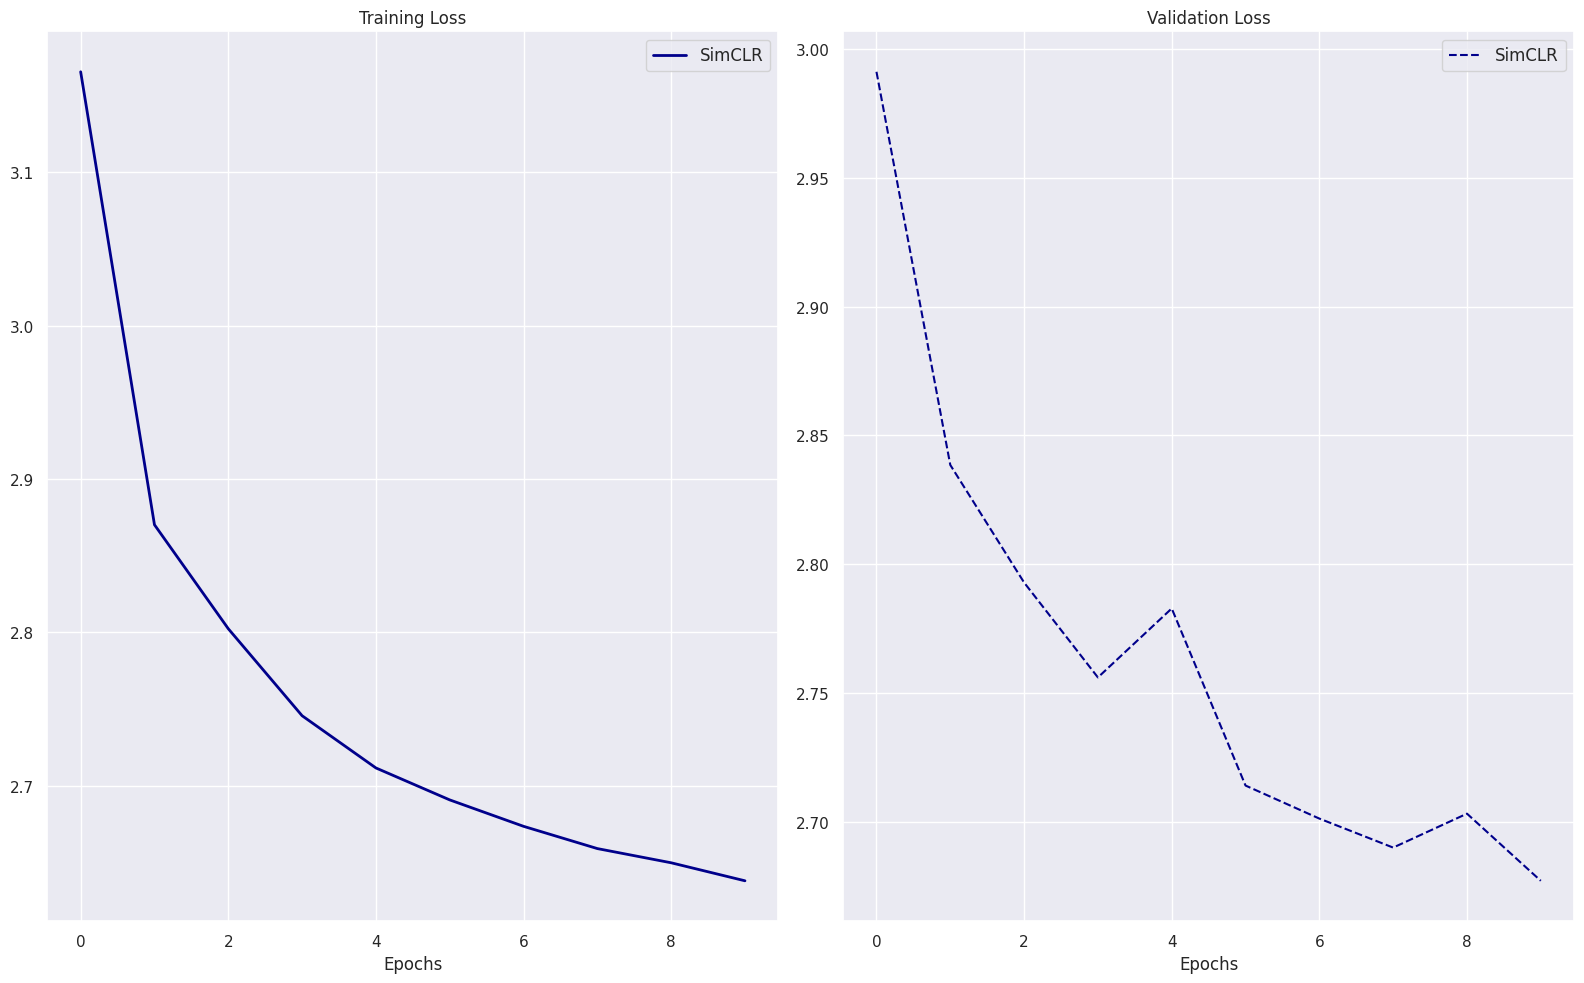

In [ ]:
histories = [history]
plot_histories(histories, ["SimCLR"])

Опустим некоторые шаги обучения модели

In [ ]:
model.load_state_dict(
    torch.load("model_60_epochs.pth", map_location=torch.device(device))
)

<All keys matched successfully>

Рассмотрим пример визуализации представлений, определяемых моделью

In [ ]:
features = []
labels = []

for images, targets in val_loader:

    images = images.to(device)

    # Передаем в модель
    with torch.no_grad():
        outputs = model(images)

    features.append(outputs)
    labels.append(targets)

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

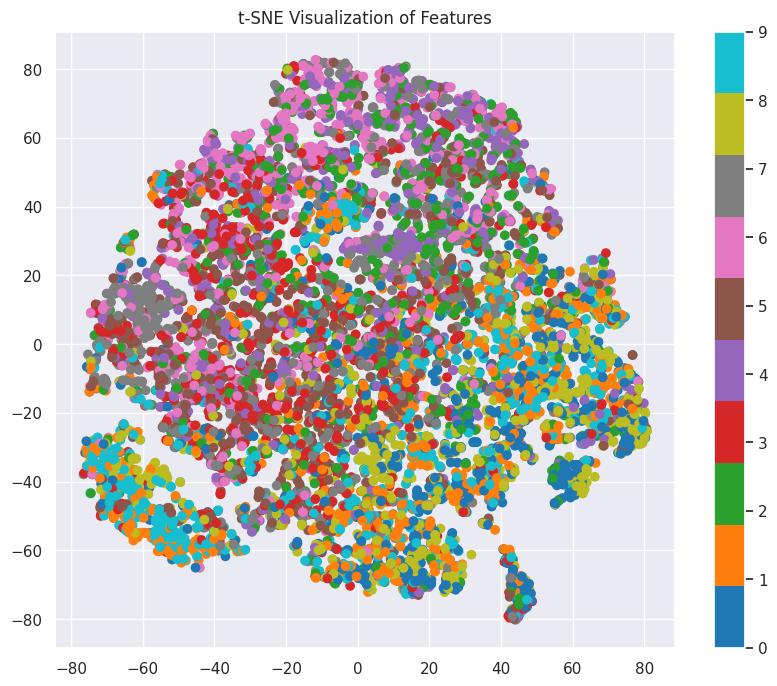

In [ ]:
from sklearn.manifold import TSNE

features_cpu = features.cpu().numpy()

features_flat = features_cpu.reshape(features_cpu.shape[0], -1)

# Применяем t-SNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization of Features')
plt.show()

Теперь рассмотрим ту же картину, но для двух классов

In [ ]:
selected_classes = [7, 8]  # Рассмотрим классы 7 и 8
selected_images = []

for images, labels in val_loader:
  for idx in range(10000):
    if labels[idx] in selected_classes and len(selected_images) < 500:
        selected_images.append((images[idx], labels[idx]))

# Извлекаем признаки
modelX = models.resnet50(pretrained=False)
num_ftrs = modelX.fc.in_features
modelX.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 128)
).to(device)
modelX.load_state_dict(
    torch.load("model_60_epochs.pth", map_location=torch.device(device))
)
modelX.fc = nn.Identity()  # Убираем полносвязный слой
modelX.to(device)
None

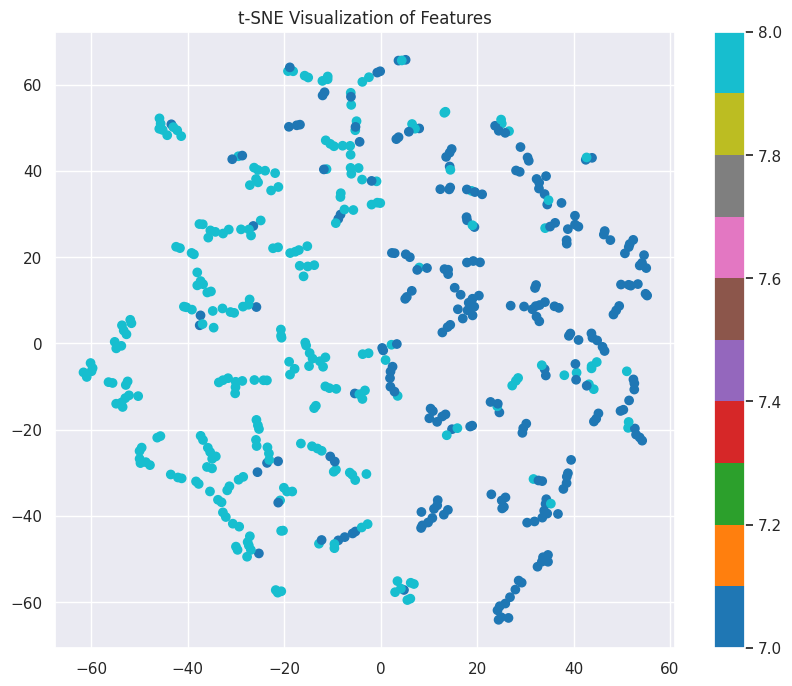

In [ ]:
features = []
labels = []

images = []
targets =[]
for image, target in selected_images:
    images.append(image)
    targets.append(target)

images = torch.stack(images)
targets = torch.tensor(targets)
images = images.to(device)

# Передаем в модель
with torch.no_grad():
  outputs = modelX(images)

features.append(outputs)
labels.append(targets)

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

from sklearn.manifold import TSNE

features_cpu = features.cpu().numpy()

features_flat = features_cpu.reshape(features_cpu.shape[0], -1)

# Применяем t-SNE
tsne = TSNE(n_components=2, perplexity=5)
features_tsne = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization of Features')
plt.show()

Как можно сделать вывод, несмотря на то, что предоставленного числа эпох недостаточно для полноценного обучения модели, попарные отношения классов определяеются гораздо точнее